In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/bradhakrishnan/ECE276A_PR2/code")
data_base_path= "/home/bradhakrishnan/ECE276A_PR2/data/"

In [3]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import expm
import jax
import matplotlib.pyplot as plt
import load_data 

jax.config.update("jax_enable_x64", True)


encoder_data= np.load(data_base_path+"Encoders20.npz")
imu_data= np.load(data_base_path+'Imu20.npz')

In [4]:
imu_angular = imu_data['angular_velocity']
imu_linear = imu_data['linear_acceleration']
imu_ts = imu_data['time_stamps']

# DATA format of encoder: [FR, FL, RR, RL]
encoder_counts= encoder_data["counts"]
encoder_ts= encoder_data["time_stamps"]

(encoder_counts, encoder_ts,
lidar_angle_min, lidar_angle_max, lidar_angle_increment,
lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamps,
imu_angular, imu_linear, imu_ts,
disp_stamps, rgb_stamps) = load_data.load_dataset(20)

In [5]:
def velocity_calculator(encoder_data, encoder_ts):
    #skipping the 0th index
    del_ts= encoder_ts[1:] - encoder_ts[:-1]
    VL = 0.5*jnp.sum(encoder_data[[0, 2], 1:], axis=0)*0.0022/del_ts
    VR = 0.5*np.sum(encoder_data[[1, 3], 1:], axis=0)*0.0022/del_ts
    robo_vel = (VL+VR)/2
    return robo_vel
    
robo_vel=velocity_calculator(encoder_counts, encoder_ts)


In [6]:
def twist_creator(lin_vel, ang_vel):
    # Create a 4x4 matrix of zeros
    twist = np.zeros((4, 4))
    
    # Set the last column to lin_vel (with a zero appended at the end)
    vel_x= lin_vel
    vel_y= 0
    vel_z=0
    twist[0:3, 3] = np.array([vel_x, vel_y, vel_z])
    
    # Set the element at first row, second column to -ang_vel[2]
    twist[0, 1] = -ang_vel[2]
    
    # Set the element at second row, first column to the third element of lin_vel
    twist[1, 0] = ang_vel[2]
    
    return twist

In [7]:
def time_sync(time_stamp_1, time_stamp_2):
    ts_synced = {}
    for ts in time_stamp_1:
        ts_synced[ts] = np.argmin(np.abs(ts-time_stamp_2))
    return ts_synced

imu_sync_map= time_sync(encoder_ts, imu_ts)
lidar_sync_map = time_sync(encoder_ts, lidar_stamps)

In [8]:
def motion_model(prev_pose, lin_vel, angular_vel,del_T):
    twist= twist_creator(lin_vel,angular_vel)
    pred_T= prev_pose@expm(del_T* twist)
    return pred_T
    

In [9]:
T_0= jnp.eye(4)
encoder_poses= [T_0]
del_ts= encoder_ts[1:] - encoder_ts[:-1]
for ii in range(0,encoder_counts.shape[-1]-1):
    ang_vel= imu_angular[:,imu_sync_map[encoder_ts[ii]]]
    lin_vel= robo_vel[ii]
    del_T= del_ts[ii]
    encoder_poses.append(motion_model(encoder_poses[ii],lin_vel, ang_vel, del_T))
encoder_poses= np.array(encoder_poses)

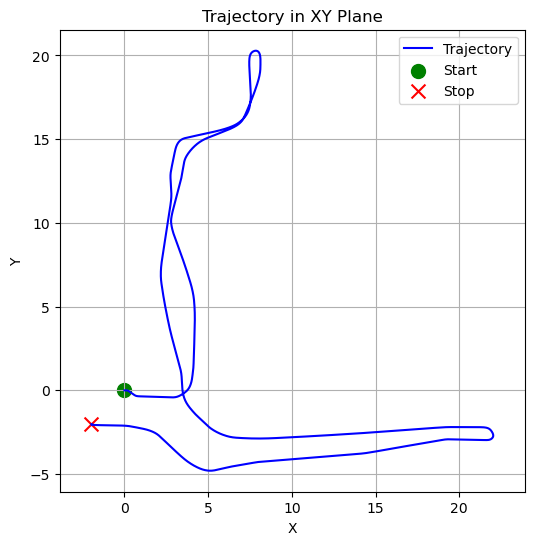

In [10]:

import matplotlib.pyplot as plt

def plot_trajectory(poses, additional_poses=None, title="Trajectory in XY Plane"):
    """
    Plots the trajectory of a sequence of poses in the XY plane.

    Parameters:
    - poses: A list or array of transformation matrices (4x4).
    - additional_poses: An optional list or array of transformation matrices (4x4) for the second trajectory to be plotted in orange.
    - title: Title for the plot (default: "Trajectory in XY Plane").
    """
    xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in poses])
    
    plt.figure(figsize=(6, 6))
    
    # Plot the primary trajectory
    plt.plot(xy_positions[:, 0], xy_positions[:, 1], label='Trajectory', color='blue')
    plt.scatter(xy_positions[0, 0], xy_positions[0, 1], color='green', label='Start', s=100, marker='o')
    plt.scatter(xy_positions[-1, 0], xy_positions[-1, 1], color='red', label='Stop', s=100, marker='x')

    if additional_poses is not None:
        additional_xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in additional_poses])
        plt.plot(additional_xy_positions[:, 0], additional_xy_positions[:, 1], label='Additional Trajectory', color='orange')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling on both axes.
    plt.legend()
    plt.show()

plot_trajectory(encoder_poses)

In [11]:
def get_lidar_pc(lidar_raw_vals,  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment):
    lidar_angles= np.linspace(lidar_angle_min, lidar_angle_max, int((lidar_angle_max - lidar_angle_min) / lidar_angle_increment) + 1)
    lidar_val_mask = np.where((lidar_raw_vals > lidar_range_min) & (lidar_raw_vals < lidar_range_max), True, False)
    lidar_raw_vals_masked = lidar_raw_vals[lidar_val_mask]
    lidar_angles_masked = lidar_angles[lidar_val_mask]
    lidar_x = lidar_raw_vals_masked * np.cos(lidar_angles_masked) 
    lidar_y = lidar_raw_vals_masked * np.sin(lidar_angles_masked)
    lidar_z = np.zeros(lidar_raw_vals_masked.shape[0])
    return np.column_stack((lidar_x,lidar_y,lidar_z))

In [12]:
# pc=get_lidar_pc(lidar_ranges[:,0],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])

In [12]:
import ICP_stuff
from tqdm import tqdm

prev_pose= T_0
accumulated_pose= T_0
lidarToBodyPose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))
trajectory= []
for idx in tqdm(range(encoder_ts.shape[0]-1)):
    # Time t data
    enc_ts_t= encoder_ts[idx]
    lidar_pc_at_t = get_lidar_pc(lidar_ranges[:,lidar_sync_map[enc_ts_t]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    # Time T+1 data
    enc_ts_t1 = encoder_ts[idx+1]
    lidar_pc_at_t1= get_lidar_pc(lidar_ranges[:,lidar_sync_map[enc_ts_t1]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    # motion model
    del_T = enc_ts_t1- enc_ts_t
    motion_model_pose = motion_model(prev_pose, lin_vel=robo_vel[ii], angular_vel=imu_angular[:,imu_sync_map[encoder_ts[ii]]], del_T=del_T  )
    icp_pose= ICP_stuff.ICP(lidar_pc_at_t1,lidar_pc_at_t, motion_model_pose)
    
    accumulated_pose= accumulated_pose@icp_pose
    trajectory.append(accumulated_pose)


  0%|          | 8/4955 [00:03<34:54,  2.36it/s]  


KeyboardInterrupt: 

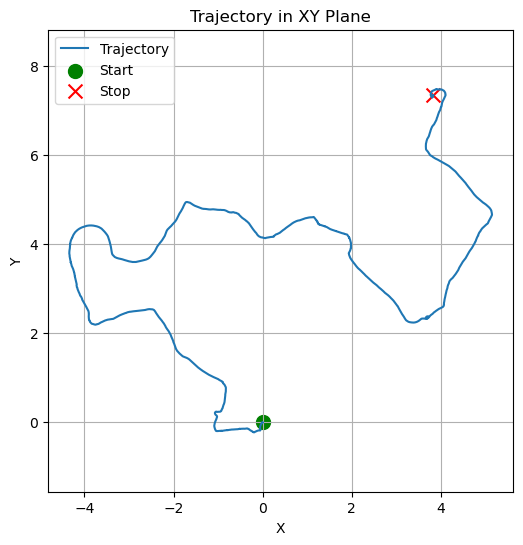

In [85]:
plot_trajectory(trajectory)

In [16]:
import ICP_stuff
from tqdm import tqdm
accumulated_pose = np.identity(4)
icp_traj = []
lidar_body_pose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))

for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts_at_t = encoder_ts[idx]
    enc_ts_at_t1 = encoder_ts[idx+1]
    encoder_pred_poses = encoder_poses[idx]

    # LTDAW stuff at time t
    lidar_range_val_at_t = lidar_ranges[:, lidar_sync_map[enc_ts_at_t]]
    lidar_pc_at_t = get_lidar_pc(lidar_range_val_at_t, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t = encoder_poses[idx] @ lidar_body_pose

    # LTDAW stuff at time t+1
    lidar_range_val_at_t1 = lidar_ranges[:, lidar_sync_map[enc_ts_at_t1]]  
    lidar_pc_at_t1 = get_lidar_pc(lidar_range_val_at_t1,lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t1 = encoder_poses[idx+1] @ lidar_body_pose

    init_pose_for_ICP = np.linalg.inv(pose_at_t) @ pose_at_t1

    icp_estimated_pose = ICP_stuff.ICP(lidar_pc_at_t, lidar_pc_at_t1, init_pose_for_ICP)

    accumulated_pose = accumulated_pose @ icp_estimated_pose
    icp_traj.append(accumulated_pose)

icp_traj = np.array(icp_traj)

100%|██████████| 4955/4955 [01:33<00:00, 53.00it/s]


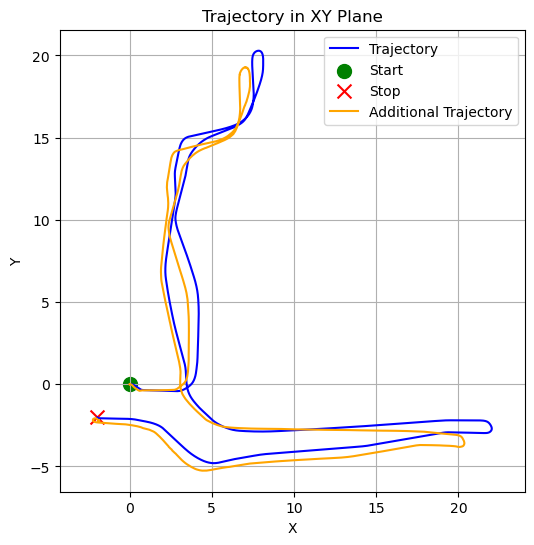

In [17]:
plot_trajectory(encoder_poses,icp_traj)

# occupancy grid

In [33]:
import numpy as np
import pr2_utils
# Initialize a grid map
MAP = {}
MAP['res'] = np.array([0.05, 0.05])    # meters
MAP['min'] = np.array([-20.0, -20.0])  # meters
MAP['max'] = np.array([20.0, 20.0])    # meters
MAP['size'] = np.ceil((MAP['max'] - MAP['min']) / MAP['res']).astype(int)
isEven = MAP['size']%2==0
MAP['size'][isEven] = MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
MAP['map'] = np.zeros(MAP['size'])

In [56]:
MAP['map'][1,1]

0.0

In [49]:
pr2_utils.bresenham2D?

Signature: pr2_utils.bresenham2D(sx, sy, ex, ey)
Docstring:
Bresenham's ray tracing algorithm in 2D.
Inputs:
        (sx, sy)      start point of ray
        (ex, ey)      end point of ray
File:      ~/ECE276A_PR2/code/pr2_utils.py
Type:      function

In [50]:
for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts = encoder_ts[idx]
    curr_pose= icp_traj[idx]
    curr_R, curr_p= ICP_stuff.get_R_and_P(curr_pose)
    
    lidar_range_val = lidar_ranges[:, lidar_sync_map[enc_ts]]
    lidar_pc= get_lidar_pc(lidar_range_val_at_t, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    lidar_pc= ICP_stuff.rotate_pc(R=curr_R, pc=lidar_pc)+curr_p
    lidar_xy_pts= lidar_pc[:,:2]
    cells = np.floor((lidar_xy_pts - MAP['min']) / MAP['res']).astype(int)
    valid2 = np.all((cells >= 0) & (cells < MAP['size']),axis=1)
    MAP['map'][tuple(cells[valid2].T)] = 1
    
    break



  0%|          | 0/4955 [00:00<?, ?it/s]


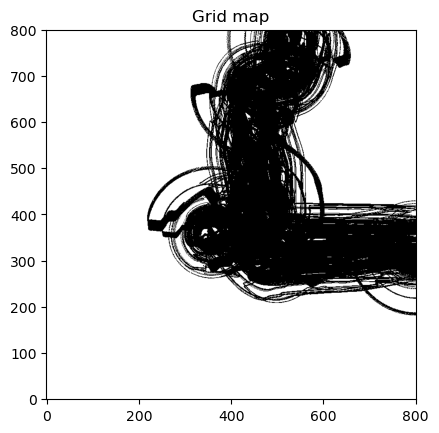

In [59]:
fig2 = plt.figure()
pr2_utils.plot_map(MAP['map'],cmap='binary')
plt.title('Grid map')

plt.show()

In [57]:
x,y

(0.0, 0.0)

In [38]:
def get_grid_coords(lidar_XY, map_size_x, map_size_y, map_res):
    for (x, y) in lidar_XY:
        # Convert world coordinates to grid coordinates
        grid_x = int((x + map_size_x / 2) / resolution)
        grid_y = int((y + map_size_y / 2) / resolution)
    return np.column_stack((grid_x, grid_y))

100%|██████████| 4955/4955 [00:01<00:00, 4699.85it/s]


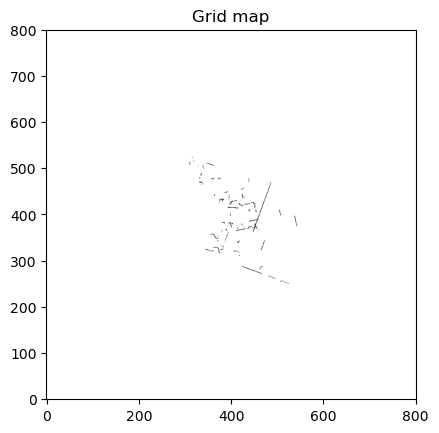

In [31]:
for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts = encoder_ts[idx]
    lidar_range_val = lidar_ranges[:, lidar_sync_map[enc_ts]]
    lidar_pc= get_lidar_pc(lidar_range_val_at_t, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    lidar_xy_pts= lidar_pc[:,:2]
    points= lidar_xy_pts
    cells = np.floor((points - MAP['min']) / MAP['res']).astype(int)
    valid2 = np.all((cells >= 0) & (cells < MAP['size']),axis=1)
    MAP['map'][tuple(cells[valid2].T)] = 1
    # Plot the Lidar points
    fig1 = plt.figure()
    plt.plot(points[:,0],points[:,1],'.k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Lidar scan')
    plt.axis('equal')
    
    # Plot the grid map
    fig2 = plt.figure()
    pr2_utils.plot_map(MAP['map'],cmap='binary')
    plt.title('Grid map')
    plt.show()
    

In [26]:
.shape

(1080, 2)